In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch.set_default_tensor_type('torch.cuda.FloatTensor')
import pandas as pd
from bs4 import BeautifulSoup
import itertools
import more_itertools
import numpy as np
import pickle


In [2]:
device

device(type='cuda')

In [3]:
## The dataset is taken from https://github.com/justmarkham/DAT7/blob/master/data/yelp.csv 
df=pd.read_csv('yelp.csv')

In [4]:
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [5]:
## mark the columns which contains text for classification and target class
col_text = 'text'
col_target = 'cool'

In [6]:
cls_arr = np.sort(df[col_target].unique()).tolist()
classes = len(cls_arr)

In [8]:
print(classes, cls_arr)

29 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 27, 28, 32, 38, 77]


In [9]:
## divide dataset in 80% train 10% validation 10% test as done in the paper
length = df.shape[0]
train_len = int(0.8*length)
val_len = int(0.1*length)
print(length, train_len, val_len)

10000 8000 1000


In [10]:
train = df[:train_len]  # train data
val = df[train_len:train_len+val_len]  # validation data
test = df[train_len+val_len:]  # test data

In [11]:
def clean_str(string, max_seq_len):
    """
    adapted from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = BeautifulSoup(string, "lxml").text
    string = re.sub(r"[^A-Za-z0-9(),!?\"\`]", " ", string)
    string = re.sub(r"\"s", " \"s", string)
    string = re.sub(r"\"ve", " \"ve", string)
    string = re.sub(r"n\"t", " n\"t", string)
    string = re.sub(r"\"re", " \"re", string)
    string = re.sub(r"\"d", " \"d", string)
    string = re.sub(r"\"ll", " \"ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    s =string.strip().lower().split(" ")
    if len(s) > max_seq_len:
        return s[0:max_seq_len] 
    return s

In [12]:
## creates a 3D list of format paragraph[sentence[word]]
def create3DList(df,col, max_sent_len,max_seq_len):
    x=[]
    for docs in df[col].as_matrix():
        x1=[]
        idx = 0
        for seq in "|||".join(re.split("[.?!]", docs)).split("|||"):
            x1.append(clean_str(seq,max_sent_len))
            if(idx>=max_seq_len-1):
                break
            idx= idx+1
        x.append(x1)
    return x

In [18]:
## Fix the maximum length of sentences in a paragraph and words in a sentence
max_sent_len = 5  # words in a sentence
max_seq_len = 10 # maximum length of sentences

In [21]:
## divides review in sentences and sentences into word creating a 3DList
x_train = create3DList(train,col_text, max_sent_len,max_seq_len)
x_val = create3DList(val, col_text, max_sent_len,max_seq_len)
x_test = create3DList(test, col_text, max_sent_len,max_seq_len)
print("x_train: {}".format(len(x_train)))
print("x_val: {}".format(len(x_val)))
print("x_test: {}".format(len(x_test)))

/home/hvdthong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


x_train: 8000
x_val: 1000
x_test: 1000


In [22]:
print(type(x_train), x_train[0])

<class 'list'> [['my', 'wife', 'took', 'me', 'here'], ['the', 'weather', 'was', 'perfect', 'which'], ['our', 'waitress', 'was', 'excellent', 'and'], ['it', 'looked', 'like', 'the', 'place'], ['do', 'yourself', 'a', 'favor', 'and'], ['it', 'was', 'phenomenal', 'and', 'simply'], ['i', 'm', 'pretty', 'sure', 'they'], ['it', 'was', 'amazing'], ['while', 'everything', 'on', 'the', 'menu'], ['it', 'came', 'with', '2', 'pieces']]


In [23]:
from gensim.models import Word2Vec
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import string

In [24]:
stoplist = stopwords.words('english') + list(string.punctuation)
stemmer = SnowballStemmer('english')
x_train_texts = [[[stemmer.stem(word.lower()) for word in sent  if word not in stoplist] for sent in para]
         for para in x_train]
x_test_texts = [[[stemmer.stem(word.lower()) for word in sent  if word not in stoplist] for sent in para]
         for para in x_test]
x_val_texts = [[[stemmer.stem(word.lower()) for word in sent  if word not in stoplist] for sent in para]
         for para in x_val]

## calculate frequency of words
from collections import defaultdict
frequency1 = defaultdict(int)
for texts in x_train_texts:     
    for text in texts:
        for token in text:
            frequency1[token] += 1
for texts in x_test_texts:     
    for text in texts:
        for token in text:
            frequency1[token] += 1
for texts in x_val_texts:     
    for text in texts:
        for token in text:
            frequency1[token] += 1
            
## remove  words with frequency less than 5.
x_train_texts = [[[token for token in text if frequency1[token] > 5]
         for text in texts] for texts in x_train_texts]

x_test_texts = [[[token for token in text if frequency1[token] > 5]
         for text in texts] for texts in x_test_texts]
x_val_texts = [[[token for token in text if frequency1[token] > 5]
         for text in texts] for texts in x_val_texts]

In [25]:
texts = list(more_itertools.collapse(x_train_texts[:] + x_test_texts[:] + x_val_texts[:],levels=1))

In [26]:
## train word2vec model on all the words
word2vec = Word2Vec(texts,size=200, min_count=5)

In [27]:
word2vec.save("dictonary_yelp")

/home/hvdthong/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [28]:
## convert 3D text list to 3D list of index 
x_train_vec = [[[word2vec.wv.vocab[token].index for token in text]
         for text in texts] for texts in x_train_texts]

In [29]:
x_test_vec = [[[word2vec.wv.vocab[token].index for token in text]
         for text in texts] for texts in x_test_texts]

In [30]:
x_val_vec = [[[word2vec.wv.vocab[token].index for token in text]
         for text in texts] for texts in x_val_texts]

In [32]:
weights = torch.FloatTensor(word2vec.wv.vectors).cuda()

In [33]:
vocab_size = len(word2vec.wv.vocab)

In [34]:
y_train = train[col_target].tolist()
y_test = test[col_target].tolist()
y_val = val[col_target].tolist()

In [35]:
## Make the the multiple attention with word vectors.
def attention_mul(rnn_outputs, att_weights):
    attn_vectors = None
    for i in range(rnn_outputs.size(0)):
        h_i = rnn_outputs[i]
        a_i = att_weights[i]
        h_i = a_i * h_i
        h_i = h_i.unsqueeze(0)
        if(attn_vectors is None):
            attn_vectors = h_i
        else:
            attn_vectors = torch.cat((attn_vectors,h_i),0)
    return torch.sum(attn_vectors, 0).unsqueeze(0)

In [36]:
## The word RNN model for generating a sentence vector
class WordRNN(nn.Module):
    def __init__(self, vocab_size,embedsize, batch_size, hid_size):
        super(WordRNN, self).__init__()
        self.batch_size = batch_size
        self.embedsize = embedsize
        self.hid_size = hid_size
        ## Word Encoder
        self.embed = nn.Embedding(vocab_size, embedsize)
        self.wordRNN = nn.GRU(embedsize, hid_size, bidirectional=True)
        ## Word Attention
        self.wordattn = nn.Linear(2*hid_size, 2*hid_size)
        self.attn_combine = nn.Linear(2*hid_size, 2*hid_size,bias=False)
    def forward(self,inp, hid_state):
        emb_out  = self.embed(inp)

        out_state, hid_state = self.wordRNN(emb_out, hid_state)

        word_annotation = self.wordattn(out_state)
        attn = F.softmax(self.attn_combine(word_annotation),dim=1)

        sent = attention_mul(out_state,attn)
        return sent, hid_state


In [37]:
## The HAN model
class SentenceRNN(nn.Module):
    def __init__(self,vocab_size,embedsize, batch_size, hid_size,c):
        super(SentenceRNN, self).__init__()
        self.batch_size = batch_size
        self.embedsize = embedsize
        self.hid_size = hid_size
        self.cls = c
        self.wordRNN = WordRNN(vocab_size,embedsize, batch_size, hid_size)
        ## Sentence Encoder
        self.sentRNN = nn.GRU(embedsize, hid_size, bidirectional=True)
        ## Sentence Attention
        self.sentattn = nn.Linear(2*hid_size, 2*hid_size)
        self.attn_combine = nn.Linear(2*hid_size, 2*hid_size,bias=False)
        self.doc_linear = nn.Linear(2*hid_size, c)
    
    def forward(self,inp, hid_state_sent, hid_state_word):
        s = None
        ## Generating sentence vector through WordRNN
        for i in range(len(inp[0])):
            r = None
            for j in range(len(inp)):
                if(r is None):
                    r = [inp[j][i]]
                else:
                    r.append(inp[j][i])
            r1 = np.asarray([sub_list + [0] * (max_seq_len - len(sub_list)) for sub_list in r])
            _s, state_word = self.wordRNN(torch.cuda.LongTensor(r1).view(-1,batch_size), hid_state_word)
            if(s is None):
                s = _s
            else:
                s = torch.cat((s,_s),0)

                out_state, hid_state = self.sentRNN(s, hid_state_sent)
        sent_annotation = self.sentattn(out_state)
        attn = F.softmax(self.attn_combine(sent_annotation),dim=1)

        doc = attention_mul(out_state,attn)
        d = self.doc_linear(doc)
        cls = F.log_softmax(d.view(-1,self.cls),dim=1)
        return cls, hid_state
    
    def init_hidden_sent(self):
            return Variable(torch.zeros(2, self.batch_size, self.hid_size)).cuda()
    
    def init_hidden_word(self):
            return Variable(torch.zeros(2, self.batch_size, self.hid_size)).cuda()


In [38]:
## converting list to tensor
y_train_tensor =  [torch.cuda.FloatTensor([cls_arr.index(label)]) for label in y_train]
y_val_tensor =  [torch.cuda.FloatTensor([cls_arr.index(label)]) for label in y_val]
y_test_tensor =  [torch.cuda.FloatTensor([cls_arr.index(label)]) for label in y_test]

In [39]:
max_seq_len = max([len(seq) for seq in itertools.chain.from_iterable(x_train_vec +x_val_vec + x_test_vec)])
max_sent_len = max([len(sent) for sent in (x_train_vec + x_val_vec + x_test_vec)])

In [40]:
max_seq_len  # maximum number of sequences in a document 

5

In [41]:
max_sent_len 

10

In [42]:
print(type(y_train_tensor))

<class 'list'>


In [43]:
np.percentile(np.array([len(seq) for seq in itertools.chain.from_iterable(x_train_vec +x_val_vec + x_test_vec)]),90)

3.0

In [44]:
np.percentile(np.array([len(sent) for sent in (x_train_vec +x_val_vec + x_test_vec)]),90)

10.0

In [45]:
## Padding the input 
X_train_pad = [sub_list + [[0]] * (max_sent_len - len(sub_list)) for sub_list in x_train_vec]
X_val_pad = [sub_list + [[0]] * (max_sent_len - len(sub_list)) for sub_list in x_val_vec]
X_test_pad = [sub_list + [[0]] * (max_sent_len - len(sub_list)) for sub_list in x_test_vec]

In [47]:
print(type(X_train_pad), type(X_val_pad), type(X_test_pad))

<class 'list'> <class 'list'> <class 'list'>


In [48]:
batch_size = 64

In [62]:
def train_data(batch_size, review, targets, sent_attn_model, sent_optimizer, criterion):

    state_word = sent_attn_model.init_hidden_word()
    state_sent = sent_attn_model.init_hidden_sent()
    sent_optimizer.zero_grad()
            
    y_pred, state_sent = sent_attn_model(review, state_sent, state_word)

    loss = criterion(y_pred.cuda(), torch.cuda.LongTensor(targets)) 

    max_index = y_pred.max(dim = 1)[1]
    correct = (max_index == torch.cuda.LongTensor(targets)).sum()
    acc = float(correct)/batch_size

    loss.backward()
    
    sent_optimizer.step()
    
#     return torch.tensor(loss).float(),acc
    return loss.clone().detach(), acc

In [50]:
hid_size = 100
embedsize = 200 

In [51]:
sent_attn = SentenceRNN(vocab_size,embedsize,batch_size,hid_size,classes)
sent_attn.cuda()
sent_attn.wordRNN.embed.from_pretrained(weights)
torch.backends.cudnn.benchmark=True

In [52]:
learning_rate = 1e-3
momentum = 0.9

sent_optimizer = torch.optim.SGD(sent_attn.parameters(), lr=learning_rate, momentum= momentum)

criterion = nn.NLLLoss()

In [53]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [54]:
def gen_batch(x,y,batch_size):
    k = random.sample(range(len(x)-1),batch_size)
    x_batch=[]
    y_batch=[]

    for t in k:
        x_batch.append(x[t])
        y_batch.append(y[t])

    return [x_batch,y_batch]

In [55]:
def validation_accuracy(batch_size, x_val,y_val,sent_attn_model):
    acc = []
    val_length = len(x_val)
    for j in range(int(val_length/batch_size)):
        x,y = gen_batch(x_val,y_val,batch_size)
        state_word = sent_attn_model.init_hidden_word()
        state_sent = sent_attn_model.init_hidden_sent()
        
        y_pred, state_sent = sent_attn_model(x, state_sent, state_word)
        max_index = y_pred.max(dim = 1)[1]
        correct = (max_index == torch.cuda.LongTensor(y)).sum()
        acc.append(float(correct)/batch_size)
    return np.mean(acc)

In [70]:
def train_early_stopping(batch_size, x_train, y_train, x_val, y_val, sent_attn_model,
                         sent_attn_optimiser, loss_criterion, num_epoch,
                         print_loss_every=50, code_test=True):
    start = time.time()
    loss_full = []
    acc_full = []
    val_acc = []
    train_length = len(x_train)
    for i in range(1, num_epoch + 1):
        loss_epoch = []
        acc_epoch = []
        for j in range(int(train_length / batch_size)):
            x, y = gen_batch(x_train, y_train, batch_size)
            loss, acc = train_data(batch_size, x, y, sent_attn_model, sent_attn_optimiser, loss_criterion)            
            loss_epoch.append(loss.item())
            acc_epoch.append(acc)
            if (code_test and j % int(print_loss_every / batch_size) == 0):
                print('Loss at %d paragraphs, %d epoch,(%s) is %f' % (
                    j * batch_size, i, timeSince(start), np.mean(loss_epoch)))
                print('Accuracy at %d paragraphs, %d epoch,(%s) is %f' % (
                    j * batch_size, i, timeSince(start), np.mean(acc_epoch)))
        loss_full.append(np.mean(loss_epoch))
        acc_full.append(np.mean(acc_epoch))
        torch.save(sent_attn_model.state_dict(), 'sent_attn_model_yelp.pth')
        print('Loss after %d epoch,(%s) is %f' % (i, timeSince(start), np.mean(loss_epoch)))
        print('Train Accuracy after %d epoch,(%s) is %f' % (i, timeSince(start), np.mean(acc_epoch)))

        val_acc.append(validation_accuracy(batch_size, x_val, y_val, sent_attn_model))
        print('Validation Accuracy after %d epoch,(%s) is %f' % (i, timeSince(start), val_acc[-1]))
    return loss_full, acc_full, val_acc


In [73]:
epoch = 200

In [74]:
loss_full, acc_full, val_acc = train_early_stopping(batch_size, X_train_pad, y_train_tensor, X_val_pad, y_val_tensor, sent_attn, sent_optimizer, criterion, epoch, 10000, False)

Loss after 1 epoch,(0m 3s) is 1.373221
Train Accuracy after 1 epoch,(0m 3s) is 0.617750
Validation Accuracy after 1 epoch,(0m 3s) is 0.639583
Loss after 2 epoch,(0m 6s) is 1.318813
Train Accuracy after 2 epoch,(0m 6s) is 0.642625
Validation Accuracy after 2 epoch,(0m 6s) is 0.615625
Loss after 3 epoch,(0m 10s) is 1.355126
Train Accuracy after 3 epoch,(0m 10s) is 0.621125
Validation Accuracy after 3 epoch,(0m 10s) is 0.645833
Loss after 4 epoch,(0m 13s) is 1.369635
Train Accuracy after 4 epoch,(0m 13s) is 0.622375
Validation Accuracy after 4 epoch,(0m 14s) is 0.631250
Loss after 5 epoch,(0m 17s) is 1.331132
Train Accuracy after 5 epoch,(0m 17s) is 0.629875
Validation Accuracy after 5 epoch,(0m 17s) is 0.654167
Loss after 6 epoch,(0m 21s) is 1.355022
Train Accuracy after 6 epoch,(0m 21s) is 0.617125
Validation Accuracy after 6 epoch,(0m 21s) is 0.635417
Loss after 7 epoch,(0m 25s) is 1.333594
Train Accuracy after 7 epoch,(0m 25s) is 0.626250
Validation Accuracy after 7 epoch,(0m 25s) is 

Loss after 57 epoch,(3m 22s) is 1.249948
Train Accuracy after 57 epoch,(3m 22s) is 0.629250
Validation Accuracy after 57 epoch,(3m 22s) is 0.642708
Loss after 58 epoch,(3m 25s) is 1.275459
Train Accuracy after 58 epoch,(3m 25s) is 0.622875
Validation Accuracy after 58 epoch,(3m 25s) is 0.619792
Loss after 59 epoch,(3m 28s) is 1.252634
Train Accuracy after 59 epoch,(3m 28s) is 0.631625
Validation Accuracy after 59 epoch,(3m 29s) is 0.598958
Loss after 60 epoch,(3m 31s) is 1.251668
Train Accuracy after 60 epoch,(3m 31s) is 0.625750
Validation Accuracy after 60 epoch,(3m 32s) is 0.625000
Loss after 61 epoch,(3m 35s) is 1.247203
Train Accuracy after 61 epoch,(3m 35s) is 0.631125
Validation Accuracy after 61 epoch,(3m 35s) is 0.639583
Loss after 62 epoch,(3m 38s) is 1.299049
Train Accuracy after 62 epoch,(3m 38s) is 0.618250
Validation Accuracy after 62 epoch,(3m 38s) is 0.608333
Loss after 63 epoch,(3m 42s) is 1.249601
Train Accuracy after 63 epoch,(3m 42s) is 0.631000
Validation Accuracy 

Loss after 113 epoch,(6m 33s) is 1.260129
Train Accuracy after 113 epoch,(6m 33s) is 0.623625
Validation Accuracy after 113 epoch,(6m 33s) is 0.625000
Loss after 114 epoch,(6m 36s) is 1.269042
Train Accuracy after 114 epoch,(6m 36s) is 0.615875
Validation Accuracy after 114 epoch,(6m 36s) is 0.629167
Loss after 115 epoch,(6m 40s) is 1.233700
Train Accuracy after 115 epoch,(6m 40s) is 0.635375
Validation Accuracy after 115 epoch,(6m 40s) is 0.643750
Loss after 116 epoch,(6m 43s) is 1.273663
Train Accuracy after 116 epoch,(6m 43s) is 0.624375
Validation Accuracy after 116 epoch,(6m 43s) is 0.636458
Loss after 117 epoch,(6m 47s) is 1.248992
Train Accuracy after 117 epoch,(6m 47s) is 0.629375
Validation Accuracy after 117 epoch,(6m 47s) is 0.625000
Loss after 118 epoch,(6m 50s) is 1.287643
Train Accuracy after 118 epoch,(6m 50s) is 0.614750
Validation Accuracy after 118 epoch,(6m 50s) is 0.644792
Loss after 119 epoch,(6m 54s) is 1.263796
Train Accuracy after 119 epoch,(6m 54s) is 0.619750


Loss after 168 epoch,(9m 37s) is 1.256444
Train Accuracy after 168 epoch,(9m 37s) is 0.625625
Validation Accuracy after 168 epoch,(9m 37s) is 0.634375
Loss after 169 epoch,(9m 41s) is 1.260993
Train Accuracy after 169 epoch,(9m 41s) is 0.625375
Validation Accuracy after 169 epoch,(9m 41s) is 0.641667
Loss after 170 epoch,(9m 44s) is 1.267667
Train Accuracy after 170 epoch,(9m 44s) is 0.624125
Validation Accuracy after 170 epoch,(9m 44s) is 0.625000
Loss after 171 epoch,(9m 47s) is 1.247122
Train Accuracy after 171 epoch,(9m 47s) is 0.625625
Validation Accuracy after 171 epoch,(9m 47s) is 0.631250
Loss after 172 epoch,(9m 50s) is 1.266407
Train Accuracy after 172 epoch,(9m 50s) is 0.624750
Validation Accuracy after 172 epoch,(9m 51s) is 0.648958
Loss after 173 epoch,(9m 53s) is 1.243988
Train Accuracy after 173 epoch,(9m 53s) is 0.632000
Validation Accuracy after 173 epoch,(9m 53s) is 0.635417
Loss after 174 epoch,(9m 57s) is 1.262513
Train Accuracy after 174 epoch,(9m 57s) is 0.624375


In [75]:
import matplotlib.pyplot as plt
plt.plot(loss_full)
plt.ylabel('Training Loss')
plt.xlabel('Epoch')
plt.savefig('loss.png')

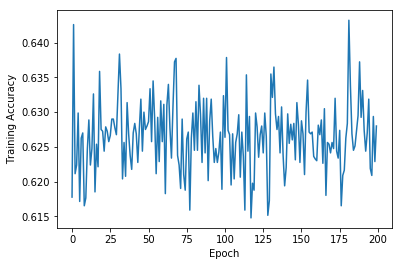

In [76]:
plt.plot(acc_full)
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')
plt.savefig('train_acc.png')

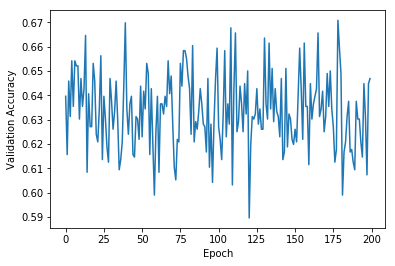

In [77]:
plt.plot(val_acc)
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.savefig('val_acc.png')

In [78]:
def test_accuracy(batch_size, x_test, y_test, sent_attn_model):
    acc = []
    test_length = len(x_test)
    for j in range(int(test_length/batch_size)):
        x,y = gen_batch(x_test,y_test,batch_size)
        state_word = sent_attn_model.init_hidden_word()
        state_sent = sent_attn_model.init_hidden_sent()
        
        y_pred, state_sent = sent_attn_model(x, state_sent, state_word)
        max_index = y_pred.max(dim = 1)[1]
        correct = (max_index == torch.cuda.LongTensor(y)).sum()
        acc.append(float(correct)/batch_size)
    return np.mean(acc)

In [79]:
test_accuracy(batch_size, X_test_pad, y_test_tensor, sent_attn)

0.6541666666666667